# Progetto Finale di Introduzione alla Data Science

## Gradimento delle App Grauite e a Pagamento
Autore: Lorenzo La Corte - S4784539

Dataset: **Google Play Store Apps**

**Obiettivo dell'analisi:**
Cerco con questa analisi di capire se è possibile che il prezzo di un'applicazione influenzi il rating;
Immagino infatti che un acquirente di un'app a pagamento sia piu' stimolato a lasciare una recensione, per comunicare agli altri se il prodotto vale o meno la spesa.
Inoltre ritengo che se un'applicazione a pagamento viene ritenuta scadente, chi l'ha acquistata sarà molto piu' spronato a lasciare una recensione negativa mentre per una scadente ma gratuita, è piu' probabile che essa venga solo disinstallata. 

**Ipotesi:**
Le ipotesi sono quindi che:
- in proporzione alle installazioni, le app a pagamento siano piu' recensite di quelle a pagamento.
- le app gratuite siano piu' gradite in generale delle app a pagamento.

## Operazioni Preliminari

Importo le librerie di base:

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import scipy.stats as stats
# !pip install scipy==1.7.0
import scipy
print (scipy.__version__)

1.7.1


Importo il dataset:

In [2]:
playstore = pd.read_csv('googleplaystore.csv') #importo il file
ps_reviews = pd.read_csv('googleplaystore_user_reviews.csv') #importo il file
playstore.head() # visualizza le prime entry del dataset

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Visualizzo numero di righe e di caratteristiche.

In [3]:
playstore.shape # restituisce (numero di righe, numero di colonne)


(10841, 13)

## Pulizia del Dataset 

Divido il dataset in features qualitative e quantitative:

In [4]:
# la [[]] crea dataframe con sezioni di caratteristiche
quantitative_playstore = playstore[['Rating','Reviews','Size','Installs','Price']] 
qualitative_playstore = playstore[['App','Category','Type','Content Rating','Genres', 'Last Updated', 'Current Ver', 'Android Ver']]

Adesso utilizzo il metodo describe() e noto che esso mi restituisce solo Rating come variabile quantitativa.



In [5]:
# quantitative_playstore.describe()
playstore.describe() # mi dovrebbe dare la stessa cosa (solo le quantitative)

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


Probabilmente devo pulire la tabella in modo da rendere 'Reviews', 'Size', 'Installs', 'Price' quantitative.

Quindi:
1. Convertire la size delle app a MB per semplificare la visualizzazione
2. Rimuovere il '+' da 'Installs' per renderlo quantitativo
3. Scoprire perché reviews e price non sono quantitative
4. Gestire i valori nulli se ci sono
5. Eliminazione dei duplicati.

## Gestione delle Variabili Quantitative

La size risulta non quantitativa: la colonna è composta da stringhe; in questo caso non gestisco questa caratteristica in quanto non mi sembra utile alle analisi; gestisco invece le altre features.

Rimuovo il '+' da 'Installs' per renderlo quantitativo:

In [6]:
if(type(playstore['Installs'][0]) is str):
    playstore = playstore[playstore.Installs != "Free"] # rimuovo le righe con questo valore per Installs
    playstore['Installs'] = [float(x.replace("+","").replace(",",".").replace(".","")) for x in playstore['Installs']]
    
playstore.describe()

,Rating,Installs
count,9366.000000,1.084000e+04
mean,4.191757,1.546434e+07
std,0.515219,8.502936e+07
min,1.000000,0.000000e+00
25%,4.000000,1.000000e+03
50%,4.300000,1.000000e+05
75%,4.500000,5.000000e+06
max,5.000000,1.000000e+09


Analizzo ora le feature Reviews e Price:

In [7]:
print(type(playstore['Reviews'][0]))
print(type(playstore['Price'][0]))


<class 'str'>
<class 'str'>


Devo convertire anche loro al fine di renderli quantitativi

In [8]:
if(type(playstore['Reviews'][0]) is str):
    playstore['Reviews'] = [float(x.replace("M","000000")) for x in playstore['Reviews']]

if(type(playstore['Price'][0]) is str):
    playstore = playstore[playstore.Price != "Everyone"] # rimuovo le righe con questo valore per Price
    playstore['Price'] = [float(x.replace("$","")) for x in playstore['Price']]

playstore.describe()

,Rating,Reviews,Installs,Price
count,9366.000000,1.084000e+04,1.084000e+04,10840.000000
mean,4.191757,4.441529e+05,1.546434e+07,1.027368
std,0.515219,2.927761e+06,8.502936e+07,15.949703
min,1.000000,0.000000e+00,0.000000e+00,0.000000
25%,4.000000,3.800000e+01,1.000000e+03,0.000000
50%,4.300000,2.094000e+03,1.000000e+05,0.000000
75%,4.500000,5.477550e+04,5.000000e+06,0.000000
max,5.000000,7.815831e+07,1.000000e+09,400.000000


## Gestione dei Valori Nulli

In [9]:
qualitative_playstore.describe()

,App,Category,Type,Content Rating,Genres,Last Updated,Current Ver,Android Ver
count,10841,10841,10840,10840,10841,10841,10833,10838
unique,9660,34,3,6,120,1378,2832,33
top,ROBLOX,FAMILY,Free,Everyone,Tools,"August 3, 2018",Varies with device,4.1 and up
freq,9,1972,10039,8714,842,326,1459,2451


Notiamo che le colonne hanno piu' o meno tutte lo stesso valore per count, quindi possiamo immaginare ci siano pochi valori nulli per le variabili quantitative, mentre i rating sembrano essere circa mille in meno; verifichiamo con:

In [10]:
# dobbiamo verificare che le entry siano nulle e non NaN o qualcos'altro
playstore.isnull().sum() # ci da tutte le occorrenze nulle

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

Prendiamo in considerazione quindi la colonna "Rating". Abbiamo due soluzioni:
1. Eliminare le righe con elementi nulli oppure
2. Provare a completarle. 

In [11]:
# Soluzione 2 (per Rating)
average_rating = playstore['Rating'].mean()
print(average_rating)
playstore['Rating'].fillna(average_rating, inplace = True) # completa i mancanti con la media degli altri

# Soluzione 1 (per i pochi altri valori nulli)
playstore.dropna(how ='any', inplace = True)

# Risultato
playstore.isnull().sum()

4.191757420456978


App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

Ho quindi adottato la soluzione del completamento per Rating e di eliminazione per gli altri valori nulli.

## Elimazione Duplicati
Come ultimo guardo se ci sono duplicati nel dataset e nel caso li rimuovo.

In [12]:
playstore[playstore.duplicated(['App'])]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
229,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80805.0,Varies with device,5000000.0,Free,0.0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up
236,Box,BUSINESS,4.2,159872.0,Varies with device,10000000.0,Free,0.0,Everyone,Business,"July 31, 2018",Varies with device,Varies with device
239,Google My Business,BUSINESS,4.4,70991.0,Varies with device,5000000.0,Free,0.0,Everyone,Business,"July 24, 2018",2.19.0.204537701,4.4 and up
256,ZOOM Cloud Meetings,BUSINESS,4.4,31614.0,37M,10000000.0,Free,0.0,Everyone,Business,"July 20, 2018",4.1.28165.0716,4.0 and up
261,join.me - Simple Meetings,BUSINESS,4.0,6989.0,Varies with device,1000000.0,Free,0.0,Everyone,Business,"July 16, 2018",4.3.0.508,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10715,FarmersOnly Dating,DATING,3.0,1145.0,1.4M,100000.0,Free,0.0,Mature 17+,Dating,"February 25, 2016",2.2,4.0 and up
10720,Firefox Focus: The privacy browser,COMMUNICATION,4.4,36981.0,4.0M,1000000.0,Free,0.0,Everyone,Communication,"July 6, 2018",5.2,5.0 and up
10730,FP Notebook,MEDICAL,4.5,410.0,60M,50000.0,Free,0.0,Everyone,Medical,"March 24, 2018",2.1.0.372,4.4 and up
10753,Slickdeals: Coupons & Shopping,SHOPPING,4.5,33599.0,12M,1000000.0,Free,0.0,Everyone,Shopping,"July 30, 2018",3.9,4.4 and up


Senbrano esserci molte app duplicate; ne analizzo una:

In [13]:
playstore[playstore['App']=="ZOOM Cloud Meetings"]


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
213,ZOOM Cloud Meetings,BUSINESS,4.4,31614.0,37M,10000000.0,Free,0.0,Everyone,Business,"July 20, 2018",4.1.28165.0716,4.0 and up
256,ZOOM Cloud Meetings,BUSINESS,4.4,31614.0,37M,10000000.0,Free,0.0,Everyone,Business,"July 20, 2018",4.1.28165.0716,4.0 and up


Effettivamente lo è; elimino quindi tutti i duplicati presenti nel dataset.

In [14]:
playstore = playstore.drop_duplicates(keep='last',subset=['App'])

Guardo ora il datastet:

In [15]:
print(playstore.shape)

playstore.describe()

(9648, 13)


,Rating,Reviews,Installs,Price
count,9648.000000,9.648000e+03,9.648000e+03,9648.000000
mean,4.176086,2.168957e+05,7.802970e+06,1.098122
std,0.494191,1.831767e+06,5.379994e+07,16.861193
min,1.000000,0.000000e+00,0.000000e+00,0.000000
25%,4.000000,2.500000e+01,1.000000e+03,0.000000
50%,4.200000,9.740000e+02,1.000000e+05,0.000000
75%,4.500000,2.944925e+04,1.000000e+06,0.000000
max,5.000000,7.812821e+07,1.000000e+09,400.000000


Abbiamo rimosso circa duemila righe ma i valori ora hanno un senso e il dataset è pulito e ordinato: siamo pronti ad una prima analisi delle feature.

# Analisi delle Feature

Cerchiamo di analizzare alcune features, per estrapolare interessanti informazioni su di esse e le loro correlazioni. 

Andiamo inanzitutto a dare un'occhiata alla tabella delle correlazioni.

In [16]:
playstore.corr().style.background_gradient(cmap="Blues")

,Rating,Reviews,Installs,Price
Rating,1.000000,0.054390,0.039311,-0.019341
Reviews,0.054390,1.000000,0.625023,-0.007594
Installs,0.039311,0.625023,1.000000,-0.009414
Price,-0.019341,-0.007594,-0.009414,1.000000


Notiamo una correlazione tra Reviews e Installs; notiamo che nello stato attuale delle cose non è indicata alcuna relazione tra prezzo e reviews.

# Analisi su Rating di App Gratuite o a Pagamento
In questa prima analisi ci concentriamo principalmente sulle feature Rating e Price, pondendoci 3 domande:

1. qual'è la distribuzione dei Rating?

2. qual'è la percentuale di app a pagamento e app gratuite?

3. T-Test: le app gratuite sono piu' gradite di quelle a pagamento?



(0.995, 1.8]      43
(1.8, 2.6]       127
(2.6, 3.4]       546
(3.4, 4.2]      4595
(4.2, 5.0]      4337
Name: Rating, dtype: int64


<AxesSubplot:>

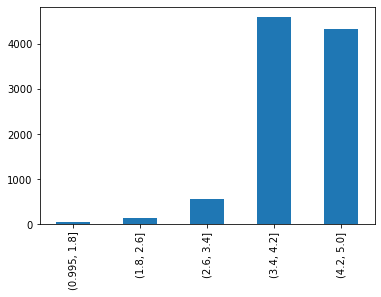

In [17]:
Ratings = playstore['Rating']
Ratings = Ratings.value_counts(bins=5, sort=False) # divido in 20 classi di prezzo 
print(Ratings)
Ratings.plot(kind = 'bar')

Notiamo che la maggior parte delle valutazioni degli utenti sono positive.

Andiamo ora ad osservare la percentuale di app a pagamento e app gratuite.

In [18]:
free_apps = playstore[playstore['Price']==0]
paid_apps = playstore[playstore['Price']>0]

perc_app_gratis = len(free_apps) / playstore.shape[0]
perc_app_pagate = len(paid_apps) / playstore.shape[0]

print("Percentuale di app gratis: " + str(perc_app_gratis))
print("Percentuale di app a pagamento: " + str(perc_app_pagate))

Percentuale di app gratis: 0.9221600331674958
Percentuale di app a pagamento: 0.07783996683250415


### T-Test: le app gratuite sono piu' gradite di quelle a pagamento?

Formuliamo ora un'ipotesi circa il gradimento di app gratuite e a pagamento, usando la seguente notazione:

H0 = "il gradimento delle app gratuite è maggiore del gradimento delle app a pagamento". 

A questo punto l'ipotesi alternativa è:

HA = "il gradimento delle app gratuite è minore o uguale del gradimento delle app a pagamento". 


Ritengo un app gradita se ha almeno 3.5 di media tra le sue recensioni.


Usiamo un **t-test a una coda** per verificare se l'ipotesi nulla è corretta.

Sappiamo che si devono verificare alcune ipotesi:
1. Campione con numero di elementi n > 30;
2. Popolazione N almeno dieci volte superiore al campione N > 10*n.

In [19]:
campione = free_apps['Rating'].sample(n = 500) # prendo un campione di 500 app scelte casualmente
print("Grandezza campione:\t\t " + str(campione.shape))
print("Media sul campione:\t\t " + str(np.mean(campione)))

popolazione_restante = paid_apps['Rating']
print("Popolazione restante:\t\t " + str(popolazione_restante.shape))
print("Media sulla popolazione restante: " + str(np.mean(popolazione_restante)))

Grandezza campione:		 (500,)
Media sul campione:		 4.107248216954943
Popolazione restante:		 (751,)
Media sulla popolazione restante: 4.24814297002532


Abbiamo considerato un campione di 500 app gratuite, e di 721 app a pagamento. 

Le condizioni del t-test sono quindi verificate, infatti:

Campione = 500 app gratuite;
Popolazione totale = 9135

Quindi le due condizioni sono verificate. 
Eseguiamo il t-test usando la libreria scipy. Scegliamo un intervallo di confidenza pari a 0.95. 

In [61]:
t_statistic, p_value = stats.ttest_1samp(a= campione, popmean= popolazione_restante.mean(),alternative='greater')
print("Statistica del Test: " + str(t_statistic))
print("p-value calcolato: " + str(p_value))

Statistica del Test: 0.05425052724986785
p-value calcolato: 0.478478077433782


*p-value > livello di confidenza*, infatti: 0.99 > 0.05

H0 è quindi accettata, quindi **il gradimento delle app gratuite è maggiore del gradimento delle app a pagamento**.


# Analisi su installazioni e recensioni di app gratuite e a pagamento.

Ipotesi: In proporzione alle installazioni, le app a pagamento siano piu' recensite di quelle a pagamento.

Creo una colonna che indica il rapporto tra numero di recensioni e numero di installazioni.

In [24]:
ps_reviews.head()
ps_reviews.shape

ps_reviews_count = ps_reviews.groupby(['App']).count()

ps_reviews_count = ps_reviews_count[['Translated_Review']]

ps_reviews_count

,Translated_Review
App,
10 Best Foods for You,194
104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室,40
11st,39
1800 Contacts - Lens Store,80
1LINE – One Line with One Touch,38
...,...
Hotspot Shield Free VPN Proxy & Wi-Fi Security,34
Hotstar,32
Hotwire Hotel & Car Rental App,33


Faccio il join delle due tabelle:

In [52]:
playstore_with_rew = playstore.set_index('App').join(ps_reviews_count)
playstore_with_rew.dropna(how ='any', inplace = True)

# verifico che il join sia avvenuto
# result[result['Translated_Review'] == 194]
# result.shape

In [53]:
rew_ratio_values = playstore_with_rew["Translated_Review"].div(playstore_with_rew["Installs"])

playstore_with_rew["Review Ratio"] = rew_ratio_values 

playstore_with_rew.shape

(1020, 14)

### T-Test: le app a pagamento hanno un rapporto Review/Installazioni piu' alto di quelle a pagamento?

Formuliamo ora un'ipotesi circa il gradimento di app gratuite e a pagamento, usando la seguente notazione:

H0 = "le app a pagamento hanno un rapporto Review/Installazioni piu' alto di quelle a pagamento". 

A questo punto l'ipotesi alternativa è:

HA = "le app a pagamento non hanno un rapporto Review/Installazioni piu' alto di quelle a pagamento". 

Usiamo un **t-test a una coda** per verificare se l'ipotesi nulla è corretta.

Sappiamo che si devono verificare alcune ipotesi:
1. Campione con numero di elementi n > 30;
2. Popolazione N almeno dieci volte superiore al campione N > 10*n.

In [86]:
free_apps_rew = playstore_with_rew[playstore_with_rew['Price']==0]
paid_apps_rew = playstore_with_rew[playstore_with_rew['Price']>0]

perc_app_gratis_rew = len(free_apps_rew) / playstore_with_rew.shape[0]
perc_app_pagate_rew = len(paid_apps_rew) / playstore_with_rew.shape[0]

print("Percentuale di app gratis: " + str(perc_app_gratis_rew))
print("Percentuale di app a pagamento: " + str(perc_app_pagate_rew))

print("\nMedia del Review Ratio per le app gratuite: \t " + str(free_apps_rew['Review Ratio'].mean()))
print("Media del Review Ratio per le app a pagamento: \t " + str(paid_apps_rew['Review Ratio'].mean()))

campione = free_apps_rew['Review Ratio'].sample(n = 100)
print("\nGrandezza campione:\t\t " + str(campione.shape))
print("Media sul campione:\t\t " + str(np.mean(campione)))

popolazione_restante = paid_apps_rew['Review Ratio']
print("Popolazione restante:\t\t " + str(popolazione_restante.shape))
print("Media sulla popolazione restante: " + str(np.mean(popolazione_restante)))

t_statistic, p_value = stats.ttest_1samp(a= campione, popmean= popolazione_restante.mean(),alternative='greater')
print("\nStatistica del Test: " + str(t_statistic))
print("p-value calcolato: " + str(p_value))

Percentuale di app gratis: 0.9833333333333333
Percentuale di app a pagamento: 0.016666666666666666

Media del Review Ratio per le app gratuite: 	 0.00012090962113659004
Media del Review Ratio per le app a pagamento: 	 0.004842823529411764

Grandezza campione:		 (100,)
Media sul campione:		 8.403194e-05
Popolazione restante:		 (17,)
Media sulla popolazione restante: 0.004842823529411764

Statistica del Test: -134.7505771980002
p-value calcolato: 1.0
